## 6. Verify Covariance Connectivity

Covariance scores very low compared to the other connectivities of the  julia2018-resting dataset. Here we test two things:

1. whether covariance \times precision would result in identity matrix. This is to make sure that the covariance matrix is not affected by near-zero or infinite values while calculating the inverse of the matrix.

2. Use another dataset to verify that the accuracy of covariance connectivity in other datasets.

In [3]:
# 0. SETUP

%reload_ext autoreload
%autoreload 3

import numpy as np
from pathlib import Path
from python.acnets.pipeline import ConnectivityPipeline, ConnectivityVectorizer
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC

In [4]:
# 1. DATA

subjects = ConnectivityPipeline().transform('all').coords['subject'].values
groups = [s[:4] for s in subjects]  # AVGP or NVGP

X = subjects.reshape(-1, 1)

y_encoder = LabelEncoder()
y = y_encoder.fit_transform(groups)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# 2. PIPELINE

pipe  = Pipeline([
    ('connectivity', ConnectivityPipeline()),
    ('vectorize', ConnectivityVectorizer()),
    ('scale', StandardScaler()),
    ('zerovar', VarianceThreshold()),
    ('select', SelectFromModel(LinearSVC(penalty='l1', dual=False, max_iter=10000), max_features=10)),
    ('clf', LinearSVC(penalty='l1', dual=False, max_iter=10000))
])

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scores:  0.90625


100%|██████████| 32/32 [00:29<00:00,  1.07it/s]


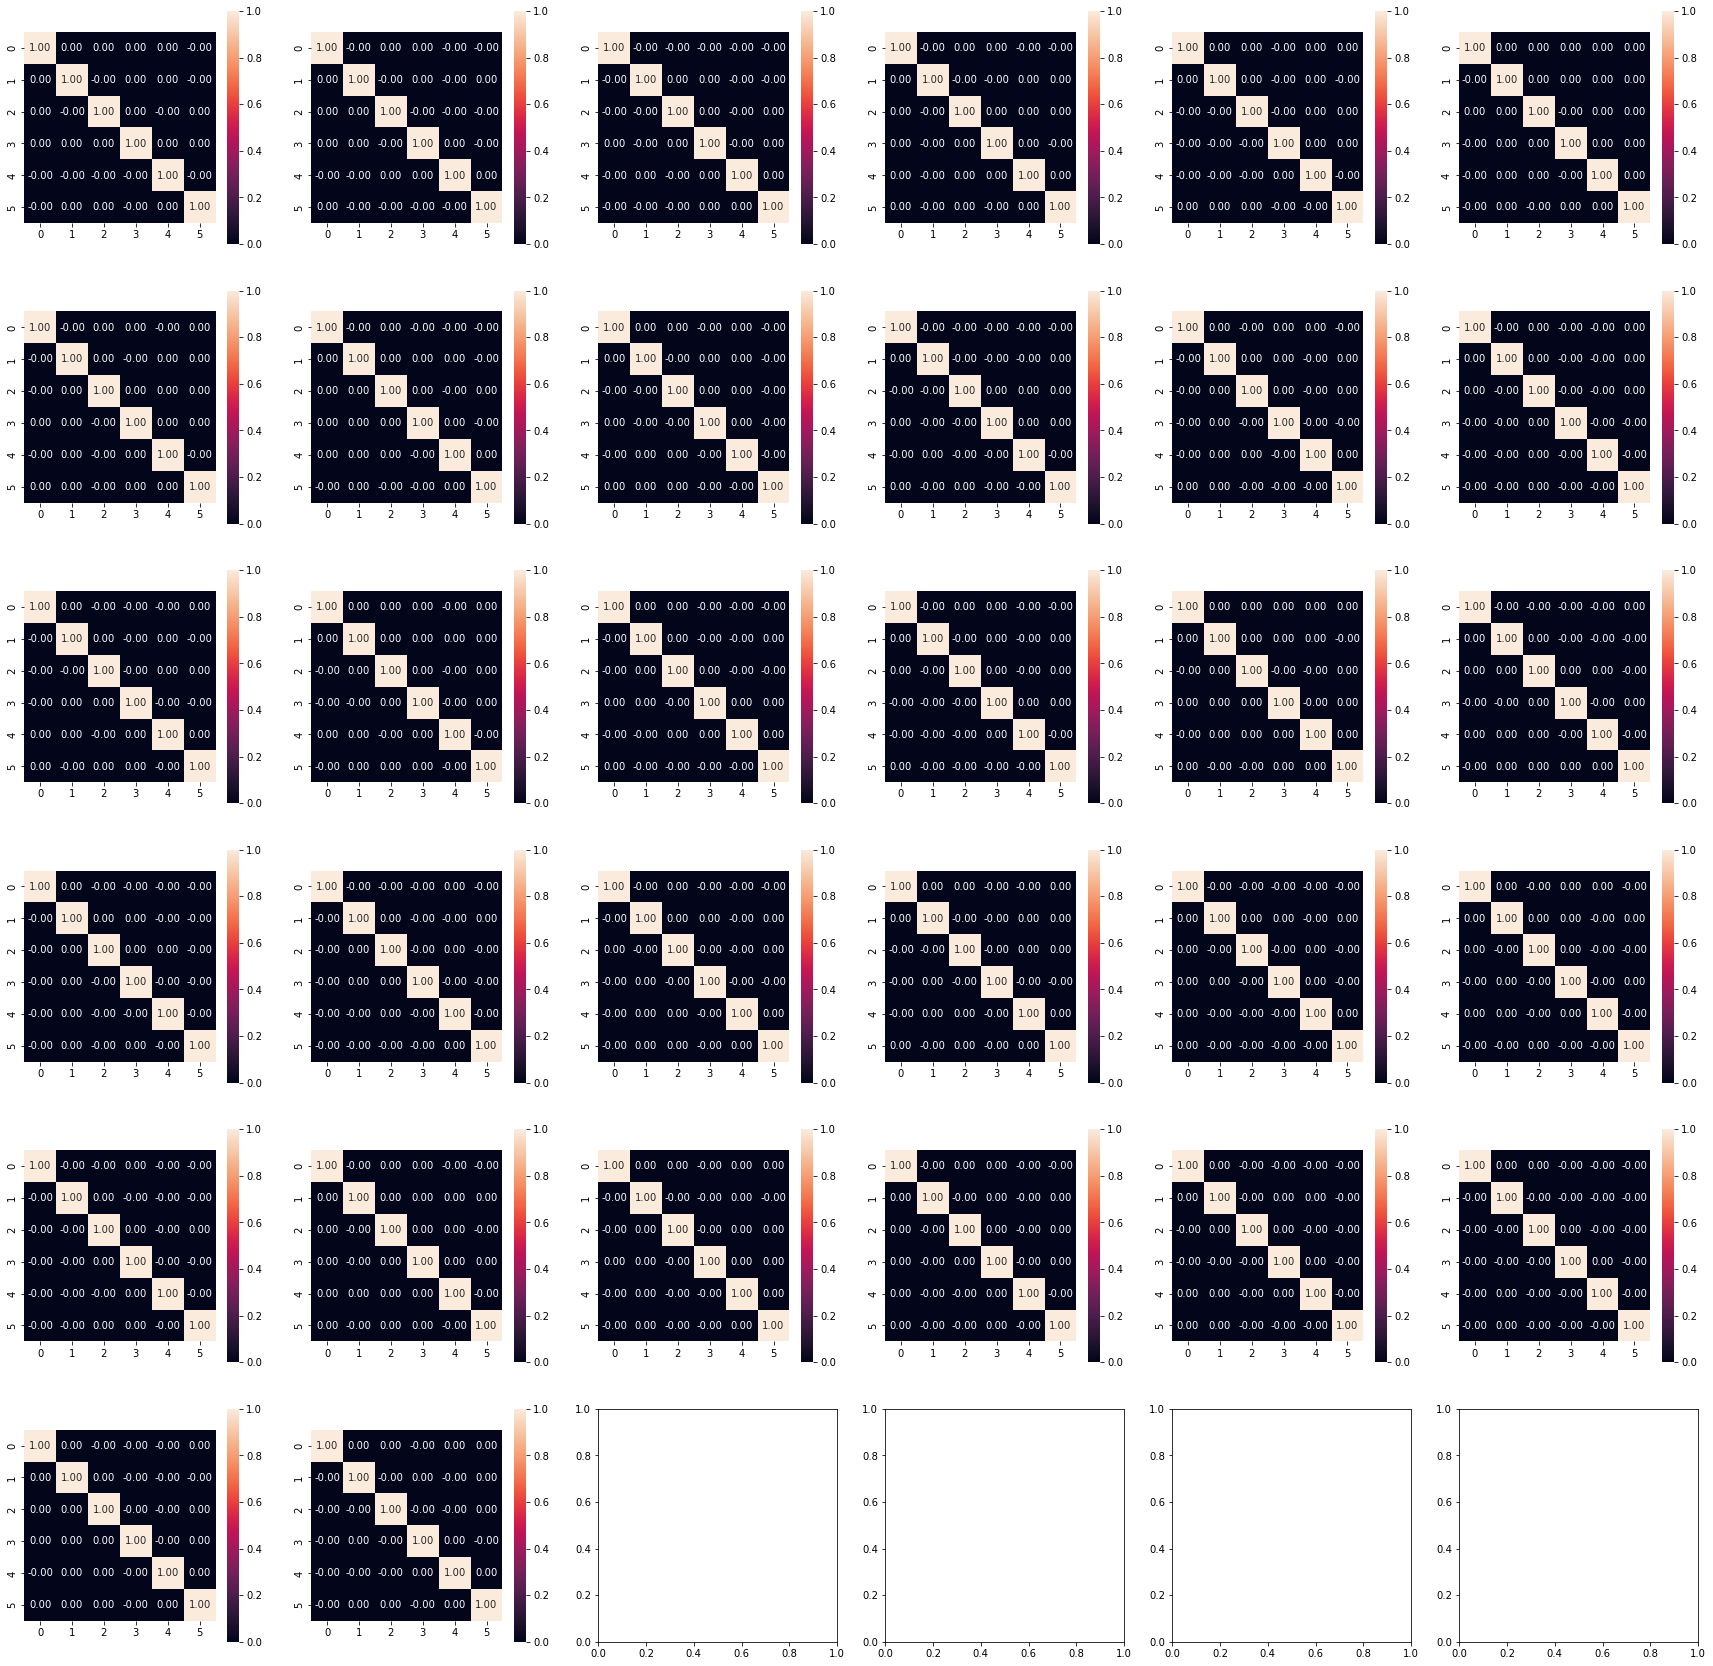

In [9]:
from tqdm.auto import tqdm
pipe.set_params(connectivity__kind='covariance')
print('scores: ', pipe.fit(X, y).score(X, y))

fig, axes = plt.subplots(6, 6, figsize=(30, 30))

for i in tqdm(range(32)):
    ax = axes.flatten()[i]
    cov_mat = pipe.named_steps['connectivity'].fit_transform(X)[i].values

    prec_mat = np.linalg.inv(cov_mat)

    # sns.heatmap(cov_mat, annot=True)
    # plt.show()

    # sns.heatmap(prec_mat, annot=True)
    # plt.show()

    sns.heatmap(cov_mat @ prec_mat, annot=True, fmt='.2f',
                robust=True, square=True, colorbar=False,
                ax=ax)
plt.show()

## Covariance Connectivity in Development Dataset

TYhe following code is borrowed from Nilearn examples to verify covariance connectivity. Here is the original code: https://nilearn.github.io/stable/auto_examples/03_connectivity/plot_group_level_connectivity.html

In [18]:
from nilearn import datasets

development_dataset = datasets.fetch_development_fmri(n_subjects=30)


msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)

from nilearn.maskers import NiftiMapsMasker

masker = NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1).fit()

children = []
pooled_subjects = []
groups = []  # child or adult
for func_file, confound_file, phenotypic in tqdm(zip(
        development_dataset.func,
        development_dataset.confounds,
        development_dataset.phenotypic)):
    time_series = masker.transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    if phenotypic['Child_Adult'] == 'child':
        children.append(time_series)
    groups.append(phenotypic['Child_Adult'])

print('Data has {0} children.'.format(len(children)))


from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import numpy as np
from nilearn.connectome import ConnectivityMeasure

kinds = ['correlation', 'covariance', 'precision', 'partial correlation', 'tangent']
_, classes = np.unique(groups, return_inverse=True)
cv = StratifiedShuffleSplit(n_splits=100, random_state=0, test_size=5)
pooled_subjects = np.asarray(pooled_subjects)

scores = {}
for kind in kinds:
    scores[kind] = []
    for train, test in cv.split(pooled_subjects, classes):
        # *ConnectivityMeasure* can output the estimated subjects coefficients
        # as a 1D arrays through the parameter *vectorize*.
        connectivity = ConnectivityMeasure(kind=kind, vectorize=True)
        # build vectorized connectomes for subjects in the train set
        connectomes = connectivity.fit_transform(pooled_subjects[train])
        # fit the classifier
        classifier = LinearSVC().fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(
            connectivity.transform(pooled_subjects[test]))
        # store the accuracy for this cross-validation fold
        scores[kind].append(accuracy_score(classes[test], predictions))

30it [00:18,  1.60it/s]


Data has 24 children.


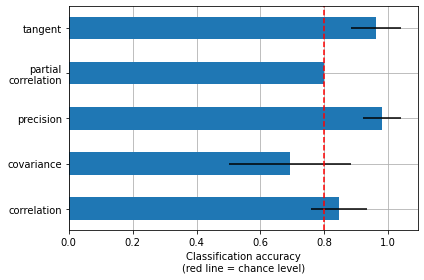

In [19]:
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
yticks = [k.replace(' ', '\n') for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(.8, color='red', linestyle='--')
plt.xlabel('Classification accuracy\n(red line = chance level)')
plt.tight_layout()